In [1]:
# -*- utf-8 -*-
# @author: tongzi
# @created date: 2019/08/20
# @description: Advanced pandas
# @last modification: 2019/08/20


In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

### 12.1 Categorical Data  
&emsp;&emsp;This section introduces the pandas $Categorical$ type. We will show how you can achieve better performance and memory use in some pandas operations by using it. We will also introduce some tools for using categorical data in statistics and machine learning applications.

#### Background and Motivation  
Frequently, a column in a table my contain repeated instances of a smaller set of distinct values. We have already seen functions like $value\_counts()$ and $unique()$, which enable us to extract the distinct values from an array and compute their frequencies, respectively.

In [3]:
values = pd.Series(['apple', 'orange', 'apple', 'apple']*2)

In [4]:
values

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
dtype: object

In [5]:
pd.unique(values)

array(['apple', 'orange'], dtype=object)

In [6]:
pd.value_counts(values)

apple     6
orange    2
dtype: int64

In [7]:
values = pd.Series([0, 1, 0, 0] * 2)

In [8]:
dim = pd.Series(['apple', 'orange'])

We can use $take()$ method to restore the original Series of strings:

In [10]:
dim.take(values)

0     apple
1    orange
0     apple
0     apple
0     apple
1    orange
0     apple
0     apple
dtype: object

#### Categorical Type in pandas  
pandas has a special $Categorical$ type that uses the integer-based categorical representation or encoding. Let's consider the example Series from before:

In [11]:
fruits = ['apple', 'orange', 'apple', 'apple'] * 2

In [12]:
N = len(fruits)

In [16]:
df = pd.DataFrame({'fruit': fruits,
                 'basket_id': np.arange(N),
                 'count': np.random.randint(3, 15, size=N),
                 'weight': np.random.uniform(0, 4, size=N)},
                 columns=['basket_id', 'fruit', 'count', 'weight'])

In [17]:
df

,basket_id,fruit,count,weight
0,0,apple,13,3.396159
1,1,orange,11,0.745182
2,2,apple,9,3.694470
3,3,apple,10,0.828363
4,4,apple,12,2.959916
5,5,orange,13,1.124178
6,6,apple,7,1.333469
7,7,apple,9,2.318679


We can convert df['fruit'] to categorical by calling:

In [18]:
fruit_cat = df['fruit'].astype('category')

In [19]:
fruit_cat

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): [apple, orange]

The values for $fruit\_cat$ are not a NumPy array, but an instance of pandas.Categorical:

In [21]:
c = fruit_cat.values
type(c)

pandas.core.categorical.Categorical

The Categorical object has $categories$ and $codes$ attributes:

In [22]:
c.categories

Index(['apple', 'orange'], dtype='object')

In [23]:
c.codes

array([0, 1, 0, 0, 0, 1, 0, 0], dtype=int8)

In [24]:
df['fruit'] = df['fruit'].astype('category')

In [26]:
df.fruit

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): [apple, orange]

We can also create $pandas.Categorical$ directly from other types of Python sequence:

In [27]:
my_categories = pd.Categorical(['foo', 'bar', 'baz', 'foo', 'bar'])

In [28]:
my_categories

[foo, bar, baz, foo, bar]
Categories (3, object): [bar, baz, foo]

If we have obtained categorical encoded data from another source, we can use the alternative $from\_codes()$ constructor:

In [31]:
categories = ['foo', 'bar', 'baz']
codes = [0, 1, 2, 0, 0, 1]

In [32]:
my_cate_2 = pd.Categorical.from_codes(codes, categories)

In [34]:
my_cate_2

[foo, bar, baz, foo, foo, bar]
Categories (3, object): [foo, bar, baz]

When using $from\_codes()$ or any of other constructors, we can indicate that the categories has a meaningful ordering:

In [36]:
ordered_cat = pd.Categorical.from_codes(codes, categories, ordered=True)

In [37]:
ordered_cat

[foo, bar, baz, foo, foo, bar]
Categories (3, object): [foo < bar < baz]

An unordered categorical instance can be made ordered with $as\_ordered()$:

In [38]:
my_cate_2.as_ordered()

[foo, bar, baz, foo, foo, bar]
Categories (3, object): [foo < bar < baz]

At a last note, categorical data need not be strings, it can consist of any immutable value types.

#### Computation with Categoricals  
Using $Categorical$ in pandas compared with the non-encoded version (like an array of strings) generally behaves in the same way. Some parts of pandas, like the $groupby()$ function, perform better when working with categoricals. There are also some functions that utilize the $ordered$ flag.  
  
Let's consider some random numeric data, and use the $pandas.qcut()$ binning function. This will return a $pandas.Categorical$ instance:

In [39]:
rng = np.random.RandomState(12345)

In [41]:
draws = rng.randn(1000)

Let's compute a quartile (四分位数) binning of this data and extract some statistics:

In [51]:
bins = pd.qcut(draws, 4)

In [52]:
bins

[(-0.684, -0.0101], (-0.0101, 0.63], (-0.684, -0.0101], (-0.684, -0.0101], (0.63, 3.928], ..., (-0.0101, 0.63], (-0.684, -0.0101], (-2.9499999999999997, -0.684], (-0.0101, 0.63], (0.63, 3.928]]
Length: 1000
Categories (4, interval[float64]): [(-2.9499999999999997, -0.684] < (-0.684, -0.0101] < (-0.0101, 0.63] < (0.63, 3.928]]

While useful, the exact sample quartiles may be less useful for producing a report than quartile names. We can achieve this with $labels$ argument to $qcut()$:

In [53]:
bins = pd.qcut(draws, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

The labeled bins categorical does note contain any information about the bins edges in the data, so we can use $groupby()$ to extract some summary statistics:

In [54]:
bins = pd.Series(bins, name='quartile')

In [55]:
res = pd.Series(draws).groupby(bins).agg(['count', 'min', 'max']).reset_index()

In [56]:
res

,quartile,count,min,max
0,Q1,250,-2.949343,-0.685484
1,Q2,250,-0.683066,-0.010115
2,Q3,250,-0.010032,0.628894
3,Q4,250,0.634238,3.927528


The 'quartile' in the $res$ retains the original categorical information including ordering, from bins:

In [58]:
res['quartile']

0    Q1
1    Q2
2    Q3
3    Q4
Name: quartile, dtype: category
Categories (4, object): [Q1 < Q2 < Q3 < Q4]

#### Better performance with categories  
If we do a lot of analytics on a particular dataset, converting to categorical can yield substantial overall performance gain. A categorical version of a DataFrame column will often will significantly less memory, too. Consider an example:

In [59]:
N = 10000000 # 10 million(1000万)

In [60]:
draws = pd.Series(np.random.randn(N))

In [61]:
labels = pd.Series(['foo', 'bar', 'baz', 'qux'] * (N // 4))

In [62]:
categories = labels.astype('category')

In [63]:
labels.memory_usage()

80000080

In [64]:
categories.memory_usage()

10000272

In [65]:
%time _ = labels.astype('category')

Wall time: 657 ms


GroupBy operations can be significantly faster with categoricals because the underlying algorithms use the integer-based codes array instead of an array of strings.

#### Categorical Methods  


In [66]:
s = pd.Series(['a', 'b', 'c', 'd'] * 2)

In [67]:
cat_s = s.astype('category')

In [68]:
cat_s

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (4, object): [a, b, c, d]

The special attribute $cat$ can provide access to categorical methods:

In [69]:
cat_s.cat.codes

0    0
1    1
2    2
3    3
4    0
5    1
6    2
7    3
dtype: int8

In [70]:
cat_s.cat.categories

Index(['a', 'b', 'c', 'd'], dtype='object')

设置新的类别：

In [71]:
actual_categories = ['a', 'b', 'c', 'd', 'e']

In [72]:
cat_s2 = cat_s.cat.set_categories(actual_categories)

In [73]:
cat_s2

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (5, object): [a, b, c, d, e]

While it appears that the data is unchanged, the new categories will be reflected in  operations that use them. For example, $value\_counts()$ respects the categories, if present:

In [74]:
cat_s.value_counts()

d    2
c    2
b    2
a    2
dtype: int64

In [75]:
cat_s2.value_counts()

d    2
c    2
b    2
a    2
e    0
dtype: int64

We can use the $remove\_unused\_categories()$ method to trim unobserved categories:

In [76]:
cat_s3 = cat_s[cat_s.isin(['a', 'b'])]

In [77]:
cat_s3

0    a
1    b
4    a
5    b
dtype: category
Categories (4, object): [a, b, c, d]

In [81]:
cat_s3.cat.remove_unused_categories()

0    a
1    b
4    a
5    b
dtype: category
Categories (2, object): [a, b]

See Table 12-1 for a listing of available categorical methods.  
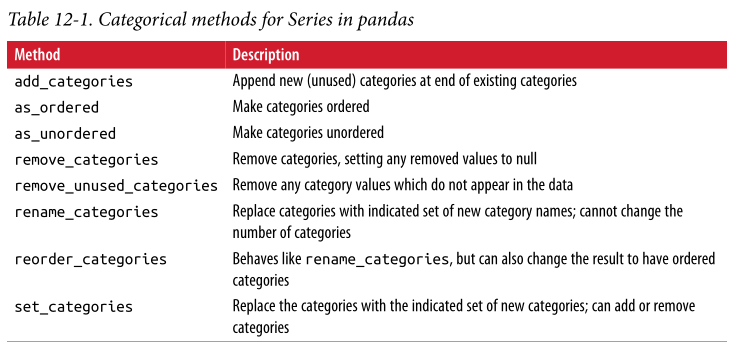

##### creating dummy variables for modeling  
When we're using statistics or machine learning tools, we'll often transform categorical data into *dummy variables*, also known as *one-hot* encoding. This involes creating a DataFrame with a column for each distinct category; these columns contain 1s for occurence of a given category and 0 otherwise.  
  
Consider the previous example:  

In [82]:
cat_s = pd.Series(['a', 'b', 'c', 'd'] * 2, dtype='category')

As mentioned in Chapter 7, the $pandas.get\_dummies()$ function converts this one-dimensional categorical data into a DataFrame containing the dummy variable:

In [83]:
pd.get_dummies(cat_s)

,a,b,c,d
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0
5,0,1,0,0
6,0,0,1,0
7,0,0,0,1


### 12.2 Advanced GroupBy Use  
While we're already discussed using the $groupby()$ method for Series and DataFrame in depth in Chapter 10, there are some additional techniques that you may find of use.

#### Group Transforms and 'Unwrapped' GroupBys  
In Chapter 10, we looked at the $apply()$ method in grouped operations for performing transformations. There is another built-in method called $transform()$, which is similar to $apply()$ but imposed more constraints on the kind of function we can use:  
  
&emsp;&emsp;(1) It can produce a scalar value to be broadcast to the shape of the group;  
&emsp;&emsp;(2) It can produce an object of the same shape as the input group;  
&emsp;&emsp;(3) It must not mutate the input.


In [84]:
df = pd.DataFrame({'key': ['a', 'b', 'c'] * 4,
                  'value': np.arange(12.)})

In [85]:
df

,key,value
0,a,0.0
1,b,1.0
2,c,2.0
3,a,3.0
4,b,4.0
5,c,5.0
6,a,6.0
7,b,7.0
8,c,8.0
9,a,9.0


In [86]:
g = df.groupby('key').value

In [88]:
g.mean()

key
a    4.5
b    5.5
c    6.5
Name: value, dtype: float64

Suppose we want to produce a Series with the same shape as df['value'] but with values replaced by the average grouped by 'key'. We can pass the function $lambda x: x.mean()$ to the $transform()$:

In [89]:
g.transform(lambda x: x.mean())

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

In [90]:
g.transform('mean')

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

Like $apply()$, $transform()$ works with functions  that return Series, but the result must be the same shape as the input. For example, we can multiply each group by 2 using a lambda function:

In [91]:
g.transform(lambda x: x*2)

0      0.0
1      2.0
2      4.0
3      6.0
4      8.0
5     10.0
6     12.0
7     14.0
8     16.0
9     18.0
10    20.0
11    22.0
Name: value, dtype: float64

We also can compute the ranks in descending order for each group:

In [93]:
g.transform(lambda x: x.rank(ascending=False))

0     4.0
1     4.0
2     4.0
3     3.0
4     3.0
5     3.0
6     2.0
7     2.0
8     2.0
9     1.0
10    1.0
11    1.0
Name: value, dtype: float64

In [94]:
pd.Series.rank?

Consider a group transformation function composed from simple aggregations:

In [95]:
def normalize(x):
    return (x - x.mean()) / x.std()

We can obtain equivalent result either using the $transform()$ or $apply()$:

In [96]:
g.transform(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

In [97]:
g.apply(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

Built-in aggregations like 'mean' or 'sum' are often much faster than a general apply function. This allows us to perform a so-called *unwrapped* group operation:

In [98]:
g.transform('mean')

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

In [101]:
%timeit normalized = (df['value'] - g.transform('mean')) / g.transform('std')

1.6 ms ± 68.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [102]:
%timeit g.transform(normalize)

2.44 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


While an unwrapped group operation may involve multiple group aggregations, the overall benifit of vectorized operaitons often outweighs this.

#### Grouped Time Resampling  
For time seris data, the $resample()$ method is semantically a group operation based on a time intervalization. Here's a small example table:

In [103]:
N = 15

In [107]:
times = pd.date_range('2019-05-20 00:00', freq='min', periods=N)

In [108]:
df = pd.DataFrame({'times': times,
                  'values': np.arange(N)})

In [109]:
df

,times,values
0,2019-05-20 00:00:00,0
1,2019-05-20 00:01:00,1
2,2019-05-20 00:02:00,2
3,2019-05-20 00:03:00,3
4,2019-05-20 00:04:00,4
5,2019-05-20 00:05:00,5
6,2019-05-20 00:06:00,6
7,2019-05-20 00:07:00,7
8,2019-05-20 00:08:00,8
9,2019-05-20 00:09:00,9


Here we can index by time, and then resample:

In [111]:
df.set_index('times').resample('5min').count()

,values
times,
2019-05-20 00:00:00,5
2019-05-20 00:05:00,5
2019-05-20 00:10:00,5


Suppose that a DataFrame contains multiple time series, marked by an additional group ky column:

In [112]:
df2 = pd.DataFrame({'time': times.repeat(3), 
                  'key': np.tile(['a', 'b', 'c'], N),
                  'value': np.arange(N*3)})

In [122]:
df2[:8]

,key,time,value
0,a,2019-05-20 00:00:00,0
1,b,2019-05-20 00:00:00,1
2,c,2019-05-20 00:00:00,2
3,a,2019-05-20 00:01:00,3
4,b,2019-05-20 00:01:00,4
5,c,2019-05-20 00:01:00,5
6,a,2019-05-20 00:02:00,6
7,b,2019-05-20 00:02:00,7


In [118]:
time_key = pd.Grouper(freq='5min')

In [119]:
resampled = (df2.set_index('time').groupby(['key', time_key]).sum())

In [120]:
resampled

value
key time                      
a   2019-05-20 00:00:00     30
    2019-05-20 00:05:00    105
    2019-05-20 00:10:00    180
b   2019-05-20 00:00:00     35
    2019-05-20 00:05:00    110
    2019-05-20 00:10:00    185
c   2019-05-20 00:00:00     40
    2019-05-20 00:05:00    115
    2019-05-20 00:10:00    190

In [123]:
resampled.reset_index()

,key,time,value
0,a,2019-05-20 00:00:00,30
1,a,2019-05-20 00:05:00,105
2,a,2019-05-20 00:10:00,180
3,b,2019-05-20 00:00:00,35
4,b,2019-05-20 00:05:00,110
5,b,2019-05-20 00:10:00,185
6,c,2019-05-20 00:00:00,40
7,c,2019-05-20 00:05:00,115
8,c,2019-05-20 00:10:00,190


### 12.3 Techniques for Method Chaining (方法链技术)  
When applying a sequence of transformations to a dataset, we may find ourself creating numerous temporary variables that are never used in our analysis.  
  
Consider this example:
```python
  df = load_data()
  df2 = df[df['col2'] < 2]
  df2['col1_demean'] = df2['col1'] - df2['col1'].mean()
  result = df2.groupby('key').col1_demean.std()

```
While we're not using any real data here, this example highlights some new methods. First, the $DataFrame.assign()$ method is a *functional* alternative to column assignments of the form $df[k]=v$. Rather than modifying the object in-place, it returns a new DataFrame with the indicated modifications. So these statements are equivalent:  
```python
  # Usual non-functional way
  df2 = df.copy()
  df2['k'] = v
    
  # Functional assign way
  df2 = df.assign(k=V)


```
Assigning in-place may execute faster than using $assign()$, but $assign()$ enables easier method chaining:  
```python
  result = df2.assign(col1_demean=df2.col1 - df2.col1.mean())
        .groupby('key')
        .col1_demean.std()
```
  
One thing to keep in mind when doing method chaining is that we may need to refer to temporary objects. In th preceding example, we cannot refer to the result of $load\_data()$ until it has been assigned to the temporary variable $df$. To help with this, $assign()$ and many pandas functions accept function-like arguments, also known as *callables*.  
  
To show callable in action, consider a fragment of the example before:  
```python
  df = load_data()
  df2 = df[df['col2'] < 0]

```
This can be rewritten as:  
```python
  df = (load_data()
       [lambda x: x['col2'] < 0])
```
Here the result of the $load\_data()$ is not assigned to a variable, so the function passed into [] is then bound to the object at the stage the method chain.  
  
We can continue, then, and write the entire expression sequence as a single chained expression:  
```python
  result = (load_data()
         [lambda x: x['col2'] < 0]
         .assign(col1_demean=lambda x: x.col1 - x.col1.mean())
         .groupby('key')
         .col1_demean.std())
```

Whether you prefer to write your codes in this style is a matter of taste, and splitting up the expression into multiple steps may make your code more readable.

#### The pipe Method  
We can accomplish a lot with the built-in pandas functions and the approaches to method chaining with callable that we just seen. However, sometimes we need to use our own functions or functions from third-party libraries. This is where the $pipe()$ method comes in.  
  
Consider a sequence of function calls:  
```python
  a = f(df, arg1=v1)
  b = g(a, v2, arg3=v3)
  c = h(b, arg4=v4)
```
When using functions that accept and return Series or DataFrame, we can rewrite this  using calls to $pipe()$:
```python
  result = (df.pipe(f, arg1=v1)
         .pipe(g, v2, arg3=v3)
         .pipe(h, arg4=v4))
```

The statement f(df) and df.pipe(f) are equivalent, but $pipe()$ makes chained invocation easier.  
  
A potential useful pattern for $pipe()$ is to generalize sequences of operations into reusable functions. As an example, let's consider subtrcting group means from a  column:  
```python
  g = df.groupby(['key1', 'key2'])
  df['col1'] = df['col1'] - g.transform('mean')
```
Suppose that we wanted to be able to demean more than one column and easily change the group keys. Additionally, we might want to perform this transformations in a method chain. Here is an example implementation:  
```python
  def group_demean(df, by, cols):
     result  =df.copy()
     g = df.groupby(by)
     for c in cols:
       result[c] = df[c] - g[c].transform('mean')
     return result

```
Then it is possible to write:  
```python
  result = (df[df.col1 < 0]
         .pipe(group_demean, ['key1', 'key2'], ['col1']))

```
